In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
import random
import pickle
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

2023-07-23 12:32:37.395757: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-23 12:32:37.449369: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 12:32:37.729836: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 12:32:37.731755: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 12:32:39.260714: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# len(weights_ann_1[0].ravel())

In [4]:
def get_targets_with_weights(batch_data, initial_ensembles, size_ens): 
    
    target_dim = 1
    
    # weights_ann_1 = ann.get_weights()
    
    # h1  = ann.layers[1].output.shape[-1]

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [5]:
def ann(hidden = 32, input_shape = 256, output_shape = 1): 
    input_layer = tf.keras.layers.Input(shape = (input_shape))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(output_shape, activation = "relu")
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [6]:
def generate_initial_ensembles(num_weights, lambda1, size_ens):
    mean_vec = np.zeros((num_weights,))
    cov_matrix = lambda1*np.identity(num_weights)
    mvn_samp = mvn(mean_vec, cov_matrix)
    return mvn_samp.rvs(size_ens)

In [7]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [8]:
samp_ann =  ann(hidden = 8, input_shape = 64, output_shape = 1)

In [9]:
weights_ann_1 = samp_ann.get_weights()

In [10]:
h1  = samp_ann.layers[1].output.shape[-1]

In [11]:
h1

8

In [12]:
samp_ann.count_params()

529

In [13]:
hidden_neurons = h1

In [14]:
samp_ann_params = samp_ann.count_params()

In [15]:
def get_initial_X_t(data1, data2, data3, data4, size_ens, var_weights = 1.0, var_weight_weights = 4.0, var_L = 1.0, var_D = 1.0):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    
    initial_ensembles1 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data1_out1, data1_stack1 = get_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens)
    
    initial_ensembles2 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data1_out2, data1_stack2 = get_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens)
    
    initial_ensembles3 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data2_out1, data2_stack1 = get_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens)
    
    initial_ensembles4 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data2_out2, data2_stack2 = get_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles_for_weights = generate_initial_ensembles(4, var_weight_weights, size_ens)
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = generate_initial_ensembles(4, var_L, size_ens)
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)    
    
    initial_ensembles_for_D1 = generate_initial_ensembles(1, var_D, size_ens).reshape(-1,1)
    # initial_ensembles_for_D2 = generate_initial_ensembles(1, var_D, size_ens).reshape(-1,1)
    
    initial_ensembles_for_D1_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    initial_ensembles_for_D2_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
    initial_ensembles_for_D3_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
    initial_ensembles_for_D = np.concatenate((np.expand_dims(initial_ensembles_for_D1,1),
                                                       np.expand_dims(initial_ensembles_for_D1_zero,1), 
                                                      np.expand_dims(initial_ensembles_for_D2_zero,1),
                                                       np.expand_dims(initial_ensembles_for_D3_zero,1)), axis = 2)
    
    # print(X_t.shape, initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4))
    
    return X_t, initial_ensembles, initial_ensembles_for_weights[:,0,:], initial_ensembles_for_D[:,0,:]

In [16]:
def get_weighted_targets_with_weights(batch_data, initial_ensembles, size_ens, weights): 
    
    target_dim = 1
    

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    final_output_1 = final_output_1*weights
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [17]:
from scipy.stats import beta

In [18]:
fudging_beta = beta(1,9)

In [19]:
def forward_operation(data1, data2, data3, data4, combined_ensembles , size_ens, fudging_beta):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann_params
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (4*params):(4*params + 4)]
    
    # initial_ensembles_for_L = combined_ensembles[:, (4*params + 4):(4*params + 4 + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(4*params + 4):(4*params + 4 + 4 )]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:, 0].reshape(-1,1) 
    
    # model_1 = np.min(model_1 -fudging_factor)
    
    model_2 = softmax_weights[:, 1].reshape(-1,1) 
    
    model_3 = softmax_weights[:, 2].reshape(-1,1) 
    
    model_4 = softmax_weights[:, 3].reshape(-1,1)
    
    sum_weights = model_1 + model_2 + model_3 + model_4
    
    
    # model_1_plus_model_2 = model_1 + model_2
    
    model_1 = model_1/sum_weights
    
    model_2 = model_2/sum_weights
    
    model_3 = model_3/sum_weights
    
    model_4 = model_4/sum_weights
    
    
    # print(np.mean(model_1 + model_2))
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                  weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens,
                                                                weights=model_2)
    
    data2_out1, data2_stack1 = get_weighted_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens,
                                                                 weights=model_3)
    
    data2_out2, data2_stack2 = get_weighted_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens,
                                                                  weights=model_4)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4, 
                        initial_ensembles_for_weights, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    final_output = data1_out1 + data1_out2 + data2_out1 + data2_out2
    
    # weighted_psa = data1_out2 + data2_out2
    
    return X_t, initial_ensembles,final_output, model_1, model_2, model_3, model_4

In [20]:
def forward_operation_test(data1, data2, data3, data4, combined_ensembles , size_ens):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann_params
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (4*params):(4*params + 4)]
    
    # initial_ensembles_for_L = combined_ensembles[:, (4*params + 4):(4*params + 4 + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(4*params + 4):(4*params + 4 + 4)]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:, :1].reshape(-1,1) 
    
    # model_1 = np.min(model_1 -fudging_factor)
    
    model_2 = softmax_weights[:, 1:2].reshape(-1,1) 
    
    model_3 = softmax_weights[:, 2:3].reshape(-1,1)
    
    model_4 = softmax_weights[:, 3:4].reshape(-1,1)
    
    sum_weights = model_1 + model_2 + model_3 + model_4
    
    
    # model_1_plus_model_2 = model_1 + model_2
    
    model_1 = model_1/sum_weights
    
    model_2 = model_2/sum_weights
    
    model_3 = model_3/sum_weights
    
    model_4 = model_4/sum_weights
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                  weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens,
                                                                weights=model_2)
    
    data2_out1, data2_stack1 = get_weighted_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens,
                                                                 weights=model_3)
    
    data2_out2, data2_stack2 = get_weighted_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens,
                                                                  weights=model_4)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4, 
                        initial_ensembles_for_weights, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    final_output = data1_out1 + data1_out2 + data2_out1 + data2_out2
    
    return X_t, initial_ensembles, final_output, model_1, model_2, model_3, model_4

In [21]:
total_weights = 4*(samp_ann.count_params() + 1 + 1)

In [22]:
reduction = 20

In [23]:
size_ens = total_weights//reduction
# total_weights//reduction

In [24]:
size_ens

106

In [25]:
G_t = [[1, 1, 1, 1]]
G_t = np.array(G_t).T

In [26]:
G_t.shape

(4, 1)

In [27]:
def get_predictions(data1, data2, data3, data4, initial_ensembles, fudging_beta  =fudging_beta): 
    _,_, weighted_alogp, w1, w2, w3, w4 = forward_operation(data1, data2, data3, data4, initial_ensembles, size_ens = size_ens, fudging_beta = fudging_beta)
    return weighted_alogp, w1, w2, w3, w4

In [28]:
def get_predictions_test(data1, data2, data3, data4, initial_ensembles): 
    _,_, weighted_alogp, w1, w2, w3, w4 = forward_operation_test(data1, data2, data3, data4, initial_ensembles, size_ens = size_ens)
    return weighted_alogp, w1, w2, w3, w4

In [29]:
def calculate_mu_bar_G_bar(data1, data2, data3, data4, initial_ensembles, fudging_beta):
    H_t = np.hstack((np.identity(data1.shape[0]), np.zeros((data1.shape[0], samp_ann_params + 1  + 1))))
    mu_bar = initial_ensembles.mean(0)
    X_t, _,_, _, _, _, _ = forward_operation(data1, data2, data3, data4, initial_ensembles, size_ens = size_ens, fudging_beta = fudging_beta)
    X_t = X_t.transpose((0,2,1))
    X_t = X_t.reshape(X_t.shape[0], X_t.shape[1]*X_t.shape[2])
    script_H_t = np.kron(G_t.T, H_t)
    G_u = (script_H_t@X_t.T)
    G_u = G_u.T
    G_bar = (G_u.mean(0)).ravel()
    return mu_bar.reshape(-1,1), G_bar.reshape(-1,1), G_u

In [30]:
def calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u): 
    u_j_minus_u_bar = initial_ensembles - mu_bar.reshape(1,-1)
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    c = np.zeros((total_weights, G_bar.shape[0]))
    for i in range(0, size_ens): 
        c += np.kron(u_j_minus_u_bar[i, :].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return c/size_ens, G_u_minus_G_bar

In [31]:
def calculate_D_u( G_bar, G_u): 
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    d = np.zeros((G_bar.shape[0], G_bar.shape[0]))
    for i in range(0, size_ens): 
        d += np.kron(G_u_minus_G_bar[i,:].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return d/size_ens

In [32]:
def get_updated_ensemble(data1, data2, data3, data4, initial_ensembles, y_train, size_ens = size_ens, inflation_factor = 1.0, fudging_beta = fudging_beta, 
                        fudging_var = None):
    mu_bar, G_bar, G_u = calculate_mu_bar_G_bar(data1, data2, data3, data4, initial_ensembles, fudging_beta)
    C, G_u_minus_G_bar = calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u)
    D = calculate_D_u( G_bar, G_u)
    _, R_t = create_cov(data1.shape[0],initial_ensembles)
    inflation = np.identity(R_t.shape[0])*inflation_factor
    D_plus_cov = D + (R_t *inflation_factor)
    D_plus_cov_inv = np.linalg.inv(D_plus_cov)
    mid_quant = C@D_plus_cov_inv
    noise_vec_mean = np.zeros((R_t.shape[0], ))
    noise_mvn = mvn(noise_vec_mean, R_t)
    fudging = noise_mvn.rvs(size_ens)
    interim = (y_train.T.flatten().reshape(1,-1) + fudging)
    right_quant = interim - G_u
    mid_times_right = mid_quant@right_quant.T
    updated_ensemble = (initial_ensembles + mid_times_right.T)
    if fudging_var is not None: 
        mean_vec = np.zeros((updated_ensemble.shape[1],))
        cov_mat = np.identity(updated_ensemble.shape[1])*fudging_var
        fudging_for_updated_ensembles = mvn(mean_vec, cov_mat)
        fudging_for_updated_ensembles_vec = fudging_for_updated_ensembles.rvs(size_ens)
        updated_ensemble = updated_ensemble + fudging_for_updated_ensembles_vec
    return updated_ensemble

In [33]:
target_dim = 1

In [34]:
lambda_D = 1

In [35]:
from joblib import Parallel, delayed

In [36]:
def create_cov(shape, initial_ensembles):
    cov_part = initial_ensembles[:, -4:-3]
    cov_part = cov_part.mean(0)
    variances1 = tf.math.softplus(cov_part).numpy()
    n = shape
    return variances1, np.identity(n)*variances1

In [37]:
# idx = 1

In [38]:
with open("..//Data//gcn_cdr_train_pca_higher.pickle", "rb") as f: 
    catch_train = pickle.load(f)

In [39]:
with open("..//Data//gcn_cdr_test_pca_higher.pickle", "rb") as f: 
    catch_test = pickle.load(f)

In [40]:
import random

In [41]:
def prepare_data_train(catch_train, idxes): 
    # idxes = random.sample(range(0, catch_train[0].shape[0]), k = size)
    # idxes = list(idxes)
    data1, data2, data3, data4 = catch_train[0][idxes,:], catch_train[1][idxes,:], catch_train[2][idxes,:], catch_train[3][idxes,:]
    
    y_train = catch_train[-1][idxes].reshape(-1,1)
    
    return data1, data2, data3, data4, y_train 

In [42]:
def prepare_data_test( catch_test, size): 
    idxes = random.sample(range(0, catch_test[0].shape[0]), k = size)
    idxes = list(idxes)
    data1, data2, data3, data4 = catch_test[0][idxes,:], catch_test[1][idxes,:], catch_test[2][idxes,:], catch_test[3][idxes,:]
    y_train = catch_test[-1][idxes].reshape(-1,1)
    return data1, data2, data3, data4, y_train

In [43]:
train_idxes = random.sample(range(0, catch_train[0].shape[0]), k = catch_train[0].shape[0])

In [44]:
data1_traina, data2_traina, data3_traina, data4_traina, y_traina =  prepare_data_train(catch_train, train_idxes)

In [45]:
data1_test, data2_test, data3_test, data4_test, y_test =  prepare_data_test(catch_test, size = catch_test[0].shape[0])

In [46]:
from scipy.stats import pearsonr

In [47]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [48]:
batch_size = 2500

In [49]:
import random

In [50]:
from tqdm import tqdm_notebook

In [51]:
def get_results(idx, var_weights = 1.0, var_weight_weights = 1.0, var_D = 0.01, inflation_factor = 1.6, fudging_beta = beta(1,19), 
               fudging_var = 1e-3, print_true = True):
    
    # smiles_feats_train, rdkit_feats_train, smiles_feats_valid, rdkit_feats_valid, y_train, y_train_actual, y_valid, y_valid_actual, initial_ensembles  = prepare_data(idx, var_weights = var_weights, var_weight_weights =var_weight_weights, var_L = var_L, var_D = var_D)
    

    train_rmse = []
    test_rmse = []
    # print("done initializing")
    
    w1_catch = []
    w2_catch = []
    w3_catch = []
    w4_catch = []
    
    
    train_idxes = random.sample(range(0, catch_train[0].shape[0]), k = catch_train[0].shape[0])
    
    train_chunks = list(chunks(train_idxes, batch_size))
    
    best_rmse_train = 10000
    
    data1_train, data2_train, data3_train, data4_train, y_train = prepare_data_train(catch_train, train_chunks[0])
    
    _, initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D = get_initial_X_t(data1_train, data2_train, data3_train, data4_train,
                                                                                                 size_ens = size_ens, var_weights = var_weights,
                                                                                                var_weight_weights = var_weight_weights,
                                                                                                             var_D = var_D)
    
    initial_ensembles = np.hstack((initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D))
    patience = 0
    
    for i in range(0,300):
        
        train_chunks = random.sample(train_chunks, len(train_chunks))
        
        if print_true == True:
            print("epoch number is " +str(i))
        
        for chunk in (train_chunks):
        
            data1_train, data2_train, data3_train, data4_train, y_train = prepare_data_train(catch_train, chunk)
            
            # X_t, initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D = get_initial_X_t(data1_train, data2_train, data3_train, data4_train,
            #                                                                                      size_ens = size_ens, var_weights = var_weights,
            #                                                                                     var_weight_weights = var_weight_weights,
            #                                                                                                  var_D = var_D)
            
            # initial_ensembles = np.hstack((initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D))

            initial_ensembles = get_updated_ensemble(data1_train, data2_train, data3_train, data4_train, initial_ensembles, y_train, size_ens = size_ens,
                                                 inflation_factor = inflation_factor, fudging_beta = fudging_beta, fudging_var = fudging_var)
        
            G_u_train, w1, w2, w3, w4 = get_predictions(data1_traina, data2_traina, data3_traina, data4_traina, initial_ensembles, fudging_beta)
    
            li_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[0,:].reshape(-1,1)    
            ui_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[1,:].reshape(-1,1)  
    
            width_train = ui_train - li_train
            avg_width_train = width_train.mean(0)[0]
    
            ind_train = (y_traina >= li_train) & (y_traina <= ui_train)
            coverage_train= ind_train.mean(0)[0]
    
            averaged_targets_train = G_u_train.mean(0).reshape(-1,1)
            rmse_train = np.sqrt(((y_traina -averaged_targets_train)**2).mean(0))[0]
        
            pearsonr_train = pearsonr(averaged_targets_train.reshape(averaged_targets_train.shape[0],), 
                                 y_traina.reshape(y_traina.shape[0],))
        
            r_train = pearsonr_train.statistic
    
            G_u_test, _, _, _, _ = get_predictions_test(data1_test, data2_test, data3_test, data4_test, initial_ensembles)
    

    
            li_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[0,:].reshape(-1,1)     
            ui_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[1,:].reshape(-1,1)   
    
            width_test = ui_test - li_test
            avg_width_test = width_test.mean(0)[0]
    
            ind_test = (y_test >= li_test) & (y_test <= ui_test)
            coverage_test= ind_test.mean(0)[0]
    
            averaged_targets_test = G_u_test.mean(0).reshape(-1,1)
            rmse_test = np.sqrt(((y_test -averaged_targets_test)**2).mean(0))[0]  
        
            pearsonr_test = pearsonr(averaged_targets_test.reshape(averaged_targets_test.shape[0],), 
                                 y_test.reshape(y_test.shape[0],))
        
            r_test = pearsonr_test.statistic
            
            train_rmse.append(rmse_train)
            
            test_rmse.append(rmse_test)
            
            
            if print_true == True:
                print("Training Coverage, Widths, RMSE, and Pearson R")
                print(coverage_train, avg_width_train, rmse_train, r_train)
                print("Testing Coverage, Widths, RMSE, and Pearson R")
                print(coverage_test, avg_width_test, rmse_test, r_test)
                print("Weight 1 Stats")
                print(w1.mean(), w1.std())
                print("Weight 2 Stats")
                print(w2.mean(), w2.std())
                print("Weight 3 Stats")
                print(w3.mean(), w3.std())
                print("Weight 4 Stats")
                print(w4.mean(), w4.std())
            
            w1_catch.append([w1.mean(), w1.std()])
            w2_catch.append([w2.mean(), w2.std()])
            w3_catch.append([w3.mean(), w3.std()])
            w4_catch.append([w4.mean(), w4.std()])
            

            if (rmse_train < best_rmse_train): 
                best_pearsonr_train = r_train
            # print("went here")
                best_train_width_mean = avg_width_train.mean()
                best_train_width = avg_width_train
                # best_smiles_weight = w1.mean()
                best_coverage_train = coverage_train
                best_rmse_train = rmse_train
                best_pearson_r = r_test
                best_test_width = avg_width_test

                best_coverage_test = coverage_test    
                best_rmse_test = rmse_test
                patience = 0
                best_ensembles = initial_ensembles
                
                best_w1_weight = w1.mean()
                best_w2_weight = w2.mean()
                best_w3_weight = w3.mean()
                best_w4_weight = w4.mean()
                
                best_test_preds = averaged_targets_test
                best_li = li_test
                best_ui = ui_test
                
                best_residuals = (y_test -averaged_targets_test)
            
            else:
                patience = patience + 1
            
            if print_true == True:
                print("Patience is")
                print(patience)
                print('\n')
        
            if patience > threshold:
                # print("train_coverage" + str(best_coverage_train), flush = True)
                print("test_coverage" + str(best_coverage_test), flush = True)
                # print("train_width" + str(best_train_width.tolist()), flush = True)
                print("test_width" + str(best_test_width), flush = True)
                # print("smiles_weight" + str(best_smiles_weight), flush = True)
                # print("rmse_train" + str(best_rmse_train.tolist()), flush = True)
                print("rmse_test" + str(best_rmse_test), flush = True)
                weights = [best_w1_weight, best_w2_weight, best_w3_weight, best_w4_weight]
                print("weights", flush = True)
                print(weights, flush = True)
                print('\n', flush = True)
                # print("smiles_weight_ci" + str([best_li_smiles_weight, best_ui_smiles_weight]), flush = True)
                test_preds = ui_test
            
                return [best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r, best_ensembles, train_rmse, test_rmse, w1_catch, w2_catch, w3_catch, w4_catch, best_w1_weight, best_w2_weight, best_w3_weight, best_w4_weight, best_test_preds, best_li, best_ui, best_residuals]


In [52]:
threshold = 10

In [53]:
%%time
best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r,  \
best_ensembles, train_rmse, test_rmse,   w1_catch, w2_catch, w3_catch, w4_catch, best_w1_weight, best_w2_weight, best_w3_weight, best_w4_weight, best_test_preds, best_li, best_ui, best_residuals = get_results(0, var_weights = 1.0, var_weight_weights = 1.0, var_D = 1, inflation_factor =1, fudging_beta = beta(1,19), 
           fudging_var = 1*1e-2, print_true = True)

epoch number is 0
Training Coverage, Widths, RMSE, and Pearson R
0.4739214609761031 4.470455520249006 3.516591982699677 0.1858711781475322
Testing Coverage, Widths, RMSE, and Pearson R
0.47401247401247404 4.4659232203779045 3.51294941180367 0.18479023882803347
Weight 1 Stats
0.09963511188689167 0.01103138410418769
Weight 2 Stats
0.4654720402728841 0.030946713219902798
Weight 3 Stats
0.10858782159931823 0.010948303660237402
Weight 4 Stats
0.326305026240906 0.026843403687696134
Patience is
0


Training Coverage, Widths, RMSE, and Pearson R
0.5121796168405236 4.12919427792158 3.0791990607066433 0.22523720362071661
Testing Coverage, Widths, RMSE, and Pearson R
0.5155347655347655 4.1304015650852985 3.0524151716587316 0.23758837040149836
Weight 1 Stats
0.06915299575129183 0.008836413663853624
Weight 2 Stats
0.45556587561064044 0.03262773946380579
Weight 3 Stats
0.09898109927068355 0.010170541326766005
Weight 4 Stats
0.37630002936738416 0.033163462143539664
Patience is
0


Training Coverage, 

In [54]:
preds_test, _, _, _, _ = get_predictions_test(data1_test, data2_test, data3_test, data4_test, best_ensembles)

In [55]:
averaged_preds_test = preds_test.mean(0).reshape(-1,1)

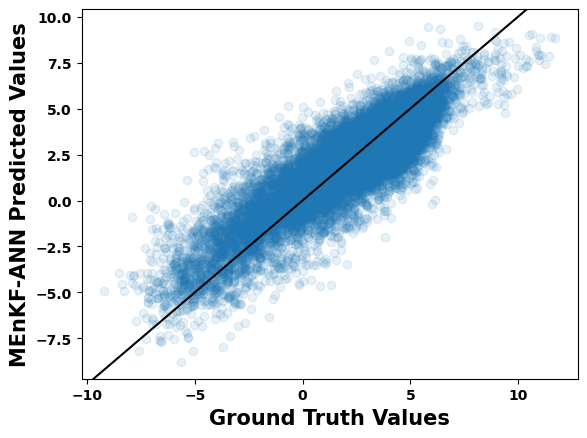

In [56]:
fig = plt.figure()
plt.scatter(y_test, averaged_preds_test, alpha = 0.1)
plt.axline((0,0), slope = 1, c = "black")
plt.xlabel("Ground Truth Values", fontweight = "bold",fontsize = 15)
plt.ylabel("MEnKF-ANN Predicted Values", fontweight = "bold", fontsize = 15)
plt.xticks(fontsize = 10, fontweight = "bold")
plt.yticks(fontsize = 10, fontweight = "bold")
# fig.savefig('MEnKF_DeepCDR_DualGCN_Scatterplot.pdf', bbox_inches='tight', format = "pdf")
# fig.savefig('MEnKF_DeepCDR_DualGCN_Scatterplot.png', bbox_inches='tight')
plt.show()

In [57]:
items = [best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r, best_w1_weight, best_w2_weight, best_w3_weight, best_w4_weight]

In [58]:
items_df = pd.DataFrame(items).T

In [59]:
items_df.columns = ['best_train_width', 'best_coverage_train', 'best_rmse_train', 'best_test_width', 'best_coverage_test', 'best_rmse_test', 'best_pearson_r', 
                   'best_w1_weight', 'best_w2_weight', 'best_w3_weight', 'best_w4_weight']

In [60]:
items_df = items_df.T

In [61]:
items_df.columns = ["Value"]

In [62]:
items_df

,Value
best_train_width,7.270820
best_coverage_train,0.956916
best_rmse_train,1.403088
best_test_width,7.282126
best_coverage_test,0.955128
best_rmse_test,1.398487
best_pearson_r,0.869474
best_w1_weight,0.017087
best_w2_weight,0.642644
best_w3_weight,0.333004


In [63]:
preds_test.shape

(106, 17316)

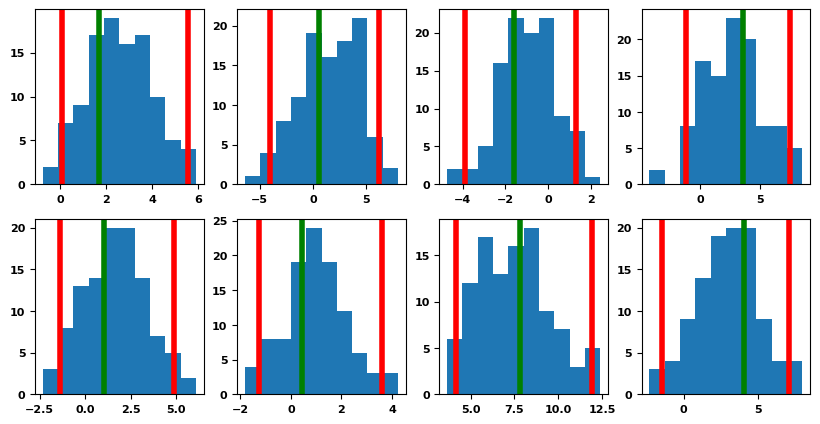

In [64]:
random_idx = random.sample(range(y_test.shape[0]), k = 8)
fig, axs = plt.subplots(2, 4,figsize=(10, 5))
# fig, axs = plt.subplots(4, 2)
axs = axs.ravel()
for idx, i in enumerate(random_idx):
    # print(counter)
    truth = y_test[i,:]
    preds = preds_test[:, i]
    percts = np.percentile(preds, axis = 0, q = (2.5, 97.5))
    lis = percts[0]
    uis = percts[1]
    
    
    axs[idx].hist(preds)
    axs[idx].axvline(truth, color='green', linewidth=4)
    axs[idx].axvline(lis, color='red', linewidth=4)
    axs[idx].axvline(uis, color='red', linewidth=4)
    plt.setp(axs[idx].get_xticklabels(), fontsize=8, fontweight="bold"
        )
    
    plt.setp(axs[idx].get_yticklabels(), fontsize=8, fontweight="bold")

# plt.title
# fig.savefig('MEnKF_DeepCDR_DualGCN_Histogram.pdf', bbox_inches='tight', format = "pdf")
# fig.savefig('MEnKF_DeepCDR_DualGCN_Histogram.png', bbox_inches='tight')
plt.show()


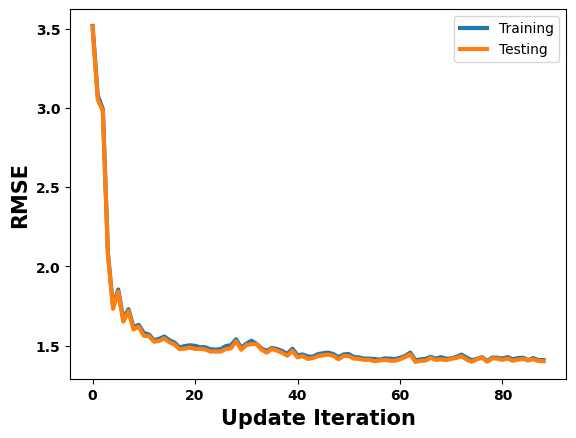

In [65]:
fig = plt.figure()
plt.plot(train_rmse, label = "Training", linewidth = 3)
plt.plot(test_rmse, label = "Testing", linewidth = 3)
plt.xlabel("Update Iteration", fontsize = 15, fontweight = "bold")
plt.ylabel("RMSE", fontsize = 15, fontweight = "bold")
plt.xticks( fontsize = 10, fontweight = "bold")
plt.yticks( fontsize = 10, fontweight = "bold")
plt.legend()
# fig.savefig('MEnKF_DeepCDR_DualGCN_RMSE_Trajectories.pdf', bbox_inches='tight', format = "pdf")
# fig.savefig('MEnKF_DeepCDR_DualGCN_RMSE_Trajectories.png', bbox_inches='tight')
plt.show()

In [66]:
# plt.hist(y_train)
# plt.show()

In [67]:
# w1_catch

In [68]:
# len(w1_catch)

In [69]:
# np.array(w1_catch)[:,0]

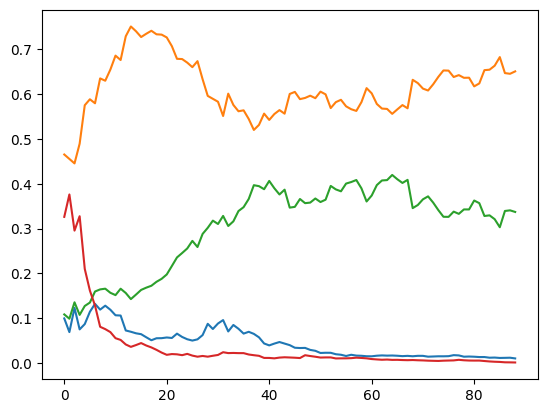

In [70]:
plt.plot(range(0,len(w1_catch)), np.array(w1_catch)[:,0])

plt.plot(range(0,len(w1_catch)), np.array(w2_catch)[:,0])

plt.plot(range(0,len(w1_catch)), np.array(w3_catch)[:,0])

plt.plot(range(0,len(w1_catch)), np.array(w4_catch)[:,0])

plt.show()

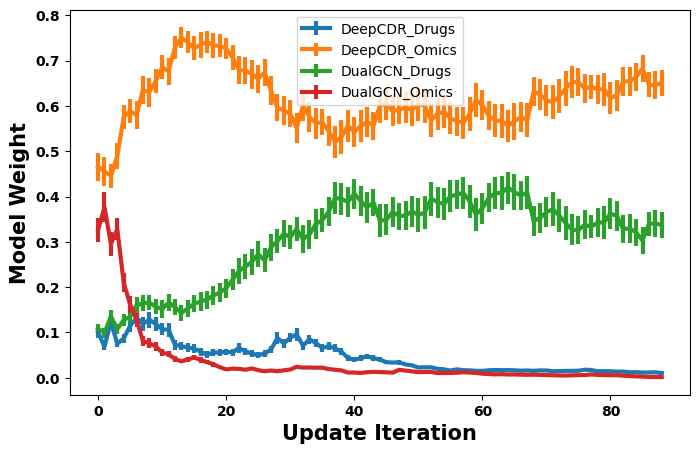

In [71]:
fig = plt.figure(figsize=(8, 5))
plt.errorbar(range(0,len(w1_catch)), np.array(w1_catch)[:,0], yerr=np.array(w1_catch)[:,1], 
            label = "DeepCDR_Drugs", linewidth = 3)

plt.errorbar(range(0,len(w1_catch)), np.array(w2_catch)[:,0], yerr=np.array(w2_catch)[:,1], 
            label = "DeepCDR_Omics", linewidth = 3)

plt.errorbar(range(0,len(w1_catch)), np.array(w3_catch)[:,0], yerr=np.array(w3_catch)[:,1], 
            label = "DualGCN_Drugs", linewidth = 3)

plt.errorbar(range(0,len(w1_catch)), np.array(w4_catch)[:,0], yerr=np.array(w4_catch)[:,1], 
            label = "DualGCN_Omics", linewidth = 3)

plt.xlabel("Update Iteration", fontsize = 15, fontweight = "bold")
plt.ylabel("Model Weight", fontsize = 15, fontweight = "bold")
plt.xticks( fontsize = 10, fontweight = "bold")
plt.yticks( fontsize = 10, fontweight = "bold")

plt.legend()
# fig.savefig('MEnKF_DeepCDR_DualGCN_Weight_Trajectories.pdf', bbox_inches='tight', format = "pdf")
# fig.savefig('MEnKF_DeepCDR_DualGCN_Weight_Trajectories.png', bbox_inches='tight')

plt.show()

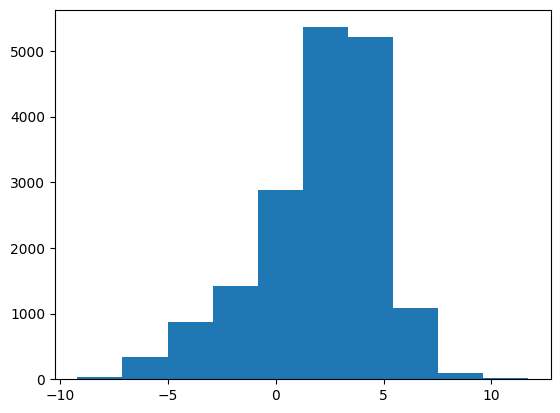

In [72]:
plt.hist(y_test)
plt.show()

In [73]:
best_test_preds

array([[ 3.39202506],
       [ 1.88076614],
       [-2.29130949],
       ...,
       [ 3.21110897],
       [ 3.22485108],
       [ 1.59167376]])

In [74]:
best_li

array([[ 0.3406747 ],
       [-2.96245824],
       [-6.80659151],
       ...,
       [ 1.12900885],
       [-0.97501013],
       [-1.25620417]])

In [75]:
best_residuals

array([[-4.12649906],
       [ 0.16925286],
       [ 0.83704049],
       ...,
       [-0.55228597],
       [ 0.01891492],
       [ 0.06756224]])

In [76]:
best_test_preds, best_li, best_ui, best_residuals

(array([[ 3.39202506],
        [ 1.88076614],
        [-2.29130949],
        ...,
        [ 3.21110897],
        [ 3.22485108],
        [ 1.59167376]]),
 array([[ 0.3406747 ],
        [-2.96245824],
        [-6.80659151],
        ...,
        [ 1.12900885],
        [-0.97501013],
        [-1.25620417]]),
 array([[6.16345578],
        [5.82477256],
        [1.55815551],
        ...,
        [5.17868702],
        [7.4820688 ],
        [4.29319548]]),
 array([[-4.12649906],
        [ 0.16925286],
        [ 0.83704049],
        ...,
        [-0.55228597],
        [ 0.01891492],
        [ 0.06756224]]))

In [77]:
from scipy.optimize import curve_fit

In [78]:
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))
    

In [79]:
# popt/

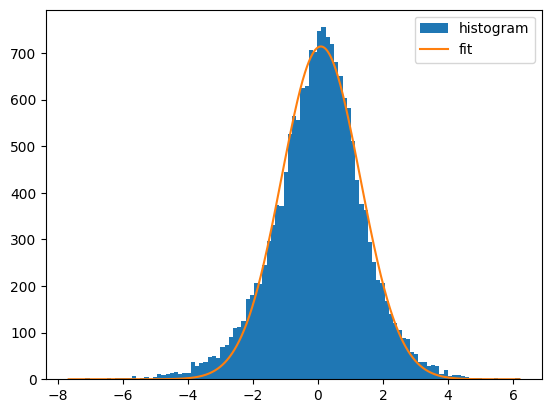

In [80]:
bin_heights, bin_borders, _ = plt.hist(best_residuals, bins='auto', label='histogram')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
plt.legend()

In [81]:
from scipy.stats import norm

In [82]:
from scipy import stats

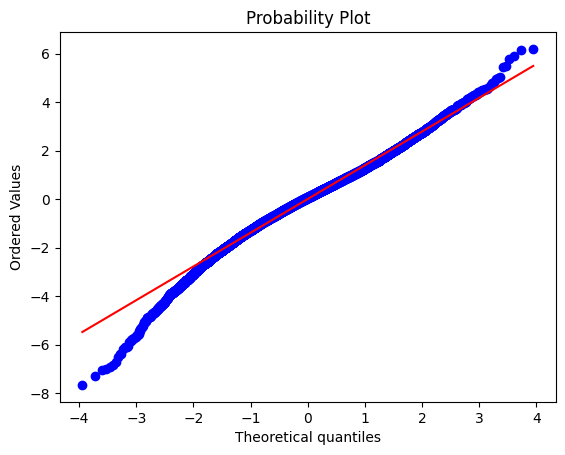

In [83]:
stats.probplot(best_residuals[:,0], dist="norm", plot=plt)
plt.show()

In [84]:
# Fit a normal distribution to the data:
mu, std = norm.fit(best_residuals)

In [85]:
mu

0.009874593190884408

In [86]:
std

1.3984518704924724

In [53]:
import multiprocessing

In [54]:
cpus = multiprocessing.cpu_count()

In [55]:
# cpus

In [56]:
import pickle

In [57]:
catch = Parallel(n_jobs = 15, verbose = 8, backend = "loky")(delayed(get_results)(idx, var_weights = 1.0, var_weight_weights = 1.0, var_D = 1, inflation_factor =1, fudging_beta = beta(1,19), 
           fudging_var = 1*1e-2, print_true = False) for idx in range(0,50))

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.


test_coverage0.9984407484407485
test_width14.28186377984953
rmse_test1.5699255253390327
weights
[0.2224184953716624, 0.08396273364996491, 0.3645341412205496, 0.32908462975782304]


test_coverage0.9996534996534997
test_width19.216205857183894
rmse_test1.4907490353048023
weights
[0.34609912354774125, 0.0663237428883831, 0.40919204348610005, 0.17838509007777556]


test_coverage0.8057865557865558
test_width3.6784055827613305
rmse_test1.3974919483842017
weights
[0.029051077744093167, 0.08080320926660058, 0.8535543143172143, 0.03659139867209204]


test_coverage0.9561099561099561
test_width9.529916336395763
rmse_test2.119302148567972
weights
[0.10265883076191333, 0.5702374551999229, 0.06989666834391464, 0.2572070456942492]


test_coverage0.9813467313467313
test_width10.03297601233951
rmse_test1.4752644243639819
weights
[0.016383155320102195, 0.8439955526212506, 0.13514141102839763, 0.004479881030249747]


test_coverage0.9544929544929545
test_width6.727421997655492
rmse_test1.3946264262519645


[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed: 82.7min


test_coverage0.9424231924231924
test_width6.452529956465438
rmse_test1.3961642979345306
weights
[0.010265426020723122, 0.5499498422501405, 0.4370501848688636, 0.002734546860272705]


test_coverage0.882998382998383
test_width4.639101812141096
rmse_test1.3845292497756596
weights
[0.03271285999495902, 0.025917418283397484, 0.9271955788242425, 0.014174142897400929]


test_coverage0.9338761838761839
test_width5.822448233420105
rmse_test1.4042922486733065
weights
[0.04248386264538579, 0.5378142379679608, 0.39584489635411624, 0.02385700303253721]


test_coverage0.9148764148764149
test_width5.243394521179563
rmse_test1.3857174650220654
weights
[0.018776873435961426, 0.048389025532835424, 0.3932941342755837, 0.5395399667556195]


test_coverage0.8011088011088011
test_width3.7050951433207513
rmse_test1.3825733847242916
weights
[0.008651896253653759, 0.010603144869482103, 0.9790711723822645, 0.0016737864945996612]


test_coverage0.7554862554862555
test_width3.275492335149466
rmse_test1.41334250386

[Parallel(n_jobs=15)]: Done  28 out of  50 | elapsed: 154.7min remaining: 121.6min


test_coverage0.8202818202818203
test_width3.9315261555054675
rmse_test1.3845985423918863
weights
[0.017737678943581543, 0.07463070554910038, 0.9022336427646137, 0.0053979727427045255]


test_coverage0.9513167013167013
test_width6.435230487474232
rmse_test1.394495630858986
weights
[0.007486092397043813, 0.026575118285650706, 0.20213098462917262, 0.7638078046881329]


test_coverage0.7572765072765073
test_width3.3194020714752477
rmse_test1.389393195483148
weights
[0.010869302156131841, 0.04358625917188401, 0.9180557190514653, 0.027488719620518937]


test_coverage0.9981519981519982
test_width14.368893714522498
rmse_test1.453633890480314
weights
[0.19904002102841065, 0.17105330866221202, 0.2038989610746717, 0.4260077092347056]


test_coverage0.8663663663663663
test_width4.307851965552565
rmse_test1.3868824460146827
weights
[0.023330505701312877, 0.34645230696554563, 0.4800178495994283, 0.15019933773371316]


test_coverage0.9654077154077154
test_width7.2594990516113285
rmse_test1.42393431614

[Parallel(n_jobs=15)]: Done  35 out of  50 | elapsed: 195.7min remaining: 83.9min


test_coverage0.7739085239085239
test_width3.5768827763365127
rmse_test1.3868591880403915
weights
[0.013924325623413116, 0.04155982707320581, 0.9382229654290053, 0.006292881874375735]


test_coverage0.9630977130977131
test_width6.654489355410722
rmse_test1.3878872151439416
weights
[0.03944796156177975, 0.013699733711632932, 0.5048700316748935, 0.44198227305169385]


test_coverage0.9936474936474936
test_width11.352021851733946
rmse_test1.678365614237517
weights
[0.09026755106661498, 0.06495505825734758, 0.07817973060459293, 0.7665976600714447]


test_coverage0.788057288057288
test_width3.6865982698866673
rmse_test1.3825357027438414
weights
[0.01768190269889302, 0.0424070788487257, 0.931466816347554, 0.008444202104827382]


test_coverage0.7625895125895126
test_width3.335423484539802
rmse_test1.3834660140307387
weights
[0.00784232235690094, 0.020044303478128116, 0.9652804312288338, 0.006832942936137402]


test_coverage0.7875375375375375
test_width3.462312682011859
rmse_test1.39651279369328

[Parallel(n_jobs=15)]: Done  42 out of  50 | elapsed: 216.6min remaining: 41.3min


test_coverage0.9260799260799261
test_width5.622848275633747
rmse_test1.4056320763002839
weights
[0.06770205024817616, 0.10536674540066279, 0.8183131484691054, 0.008618055882055522]


test_coverage0.7475167475167476
test_width3.3046008153399313
rmse_test1.3893747528631102
weights
[0.014476411670235254, 0.032555846657156794, 0.9401384845051404, 0.01282925716746763]


test_coverage0.8817856317856317
test_width4.699049575599137
rmse_test1.383131901012163
weights
[0.057982520467437036, 0.13594093856715017, 0.7107765682185926, 0.0952999727468202]


test_coverage0.9089281589281589
test_width5.196141381566004
rmse_test1.4060526269416516
weights
[0.06756984135591577, 0.026620932408477148, 0.7954521713869552, 0.11035705484865181]


test_coverage0.9741857241857241
test_width8.908304130884801
rmse_test1.4286585938816125
weights
[0.018544974336403, 0.7084612408233526, 0.27128396920992226, 0.0017098156303222759]


test_coverage0.9695657195657196
test_width7.162679755822427
rmse_test1.40225652640588


[Parallel(n_jobs=15)]: Done  50 out of  50 | elapsed: 257.2min finished


In [58]:
with open("..//Data//DeepCDR_DualGCN_combo_run_plot_from_jupyter_all_train.pickle", "wb") as f: 
    pickle.dump(catch, f)

In [59]:
with open("..//Data//DeepCDR_DualGCN_combo_run_plot_from_jupyter_all_train.pickle", "rb") as f: 
    catch = pickle.load(f)

In [60]:
all_metrics = []
all_weights = []
for i in range(0,50):
    item = catch[i]
    metrics = item[:7]
    weights = item[-8:-4]
    all_metrics.append(metrics)
    all_weights.append(weights)
    

In [61]:
import pandas as pd

In [62]:
all_metrics_df = pd.DataFrame(all_metrics)

In [63]:
all_weights_df = pd.DataFrame(all_weights)

In [64]:
all_df = pd.concat([all_metrics_df, all_weights_df], axis = 1)

In [65]:
all_df.columns = ['train_width', 'coverage_train', 'rmse_train', 'test_width', 'coverage_test', 'rmse_test', 'pearson_r', 
                   "DeepCDR_Drugs", "DeepCDR_Omics", "DualGCN_Drugs", "DualGCN_Omics"]

In [66]:
all_df.head()

,train_width,coverage_train,rmse_train,test_width,coverage_test,rmse_test,pearson_r,DeepCDR_Drugs,DeepCDR_Omics,DualGCN_Drugs,DualGCN_Omics
0,6.754730,0.955284,1.406912,6.727422,0.954493,1.394626,0.870586,0.074258,0.049837,0.808173,0.067732
1,4.054756,0.839454,1.394486,4.025614,0.834200,1.387617,0.871973,0.024891,0.013759,0.861897,0.099453
2,5.249609,0.913255,1.394269,5.243395,0.914876,1.385717,0.872060,0.018777,0.048389,0.393294,0.539540
3,4.664708,0.884388,1.395774,4.639102,0.882998,1.384529,0.872553,0.032713,0.025917,0.927196,0.014174
4,4.749065,0.878464,1.392033,4.728391,0.880053,1.385229,0.872141,0.029521,0.023505,0.936477,0.010497


In [67]:
all_df.mean()

train_width       6.014067
coverage_train    0.883411
rmse_train        1.433157
test_width        5.994930
coverage_test     0.881422
rmse_test         1.425031
pearson_r         0.862968
DeepCDR_Drugs     0.049736
DeepCDR_Omics     0.142913
DualGCN_Drugs     0.648789
DualGCN_Omics     0.158563
dtype: float64

In [68]:
all_df.std()

train_width       3.427129
coverage_train    0.077313
rmse_train        0.114138
test_width        3.425471
coverage_test     0.078656
rmse_test         0.112833
pearson_r         0.030902
DeepCDR_Drugs     0.063680
DeepCDR_Omics     0.202855
DualGCN_Drugs     0.284480
DualGCN_Omics     0.217951
dtype: float64

In [69]:
current_test = [data1_test, data2_test, data3_test, data4_test, y_test]

In [70]:
with open("..//Data//DeepCDR_DualGCN_combo_run_plot_from_jupyter_test_features_and_ground_truth_all_train.pickle", "wb") as f: 
    pickle.dump(current_test, f)

In [71]:
# best_test_preds, best_li, best_ui, best_residuals

In [72]:
catch[0][-4:][-1].shape

(17316, 1)

In [74]:
# bin_heights, bin_borders, _ = plt.hist(catch[0][-4:][-1], bins='auto', label='histogram')
# bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
# popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

# x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
# plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
# plt.legend()

In [76]:
from scipy import stats

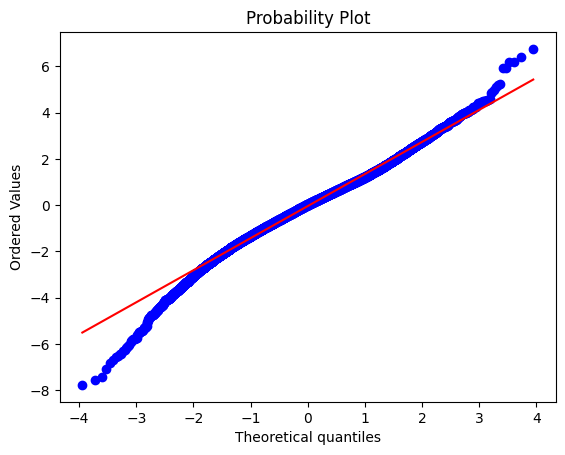

In [77]:
stats.probplot(catch[0][-4:][-1][:,0], dist="norm", plot=plt)
plt.show()